# Future Sales Prediction - Kaggle Competition

https://www.kaggle.com/competitions/competitive-data-science-predict-future-sales/

#### File descriptions
- sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.

- test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.

- sample_submission.csv - a sample submission file in the correct format.

- items.csv - supplemental information about the items/products.

- item_categories.csv  - supplemental information about the items categories.

- shops.csv- supplemental information about the shops.

#### Data fields

- ID - an Id that represents a (Shop, Item) tuple within the test set

- shop_id - unique identifier of a shop

- item_id - unique identifier of a product

- item_category_id - unique identifier of item category

- item_cnt_day - number of products sold. You are predicting a monthly amount of this measure

- item_price - current price of an item

- date - date in format dd/mm/yyyy

- date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33

- item_name - name of item

- shop_name - name of shop

- item_category_name - name of item category

### I. Import the dataset and data analysis libraries

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [79]:
sales_train = pd.read_csv("data/sales_train.csv")
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [80]:
test = pd.read_csv("data/test.csv")
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [81]:
sample_submission = pd.read_csv("data/sample_submission.csv")
print(sample_submission.shape)
sample_submission.head()

(214200, 2)


,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [82]:
items = pd.read_csv("data/items.csv")
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [83]:
item_categories = pd.read_csv("data/item_categories.csv")
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [84]:
shops = pd.read_csv("data/shops.csv")
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


### II. Initial data checks and manipulations

In [85]:
sales_train.shape

(2935849, 6)

In [86]:
sales_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


Note that the ```date``` column is not in the proper datetime format.

In [87]:
sales_train['date'] = pd.to_datetime(sales_train['date'], format = '%d.%m.%Y')
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [88]:
# Split into month, day, and year
sales_train['year'] = sales_train['date'].dt.year
sales_train['month'] = sales_train['date'].dt.month
sales_train['day'] = sales_train['date'].dt.day
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month,day
0,2013-01-02,0,59,22154,999.00,1.0,2013,1,2
1,2013-01-03,0,25,2552,899.00,1.0,2013,1,3
2,2013-01-05,0,25,2552,899.00,-1.0,2013,1,5
3,2013-01-06,0,25,2554,1709.05,1.0,2013,1,6
4,2013-01-15,0,25,2555,1099.00,1.0,2013,1,15


In [89]:
# Keep the month-year pair (in string format) to make date_block_num column more intelligible
sales_train['month_year'] = sales_train['date'].dt.strftime('%Y-%m-%d').str[:7]

# dt.strftime(...) to convert the datetime format of 'date' into string format
# str[:7] to extract the month and year in the date string

sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month,day,month_year
0,2013-01-02,0,59,22154,999.00,1.0,2013,1,2,2013-01
1,2013-01-03,0,25,2552,899.00,1.0,2013,1,3,2013-01
2,2013-01-05,0,25,2552,899.00,-1.0,2013,1,5,2013-01
3,2013-01-06,0,25,2554,1709.05,1.0,2013,1,6,2013-01
4,2013-01-15,0,25,2555,1099.00,1.0,2013,1,15,2013-01


In [90]:
sales_train.isna().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
year              0
month             0
day               0
month_year        0
dtype: int64

In [91]:
sales_train.nunique()

date               1034
date_block_num       34
shop_id              60
item_id           21807
item_price        19993
item_cnt_day        198
year                  3
month                12
day                  31
month_year           34
dtype: int64

In [92]:
# Describing datetime and quantitative variables
sales_train[['date', 'item_price', 'item_cnt_day']].describe()

,date,item_price,item_cnt_day
count,2935849,2.935849e+06,2.935849e+06
mean,2014-04-03 05:44:34.970681344,8.908532e+02,1.242641e+00
min,2013-01-01 00:00:00,-1.000000e+00,-2.200000e+01
25%,2013-08-01 00:00:00,2.490000e+02,1.000000e+00
50%,2014-03-04 00:00:00,3.990000e+02,1.000000e+00
75%,2014-12-05 00:00:00,9.990000e+02,1.000000e+00
max,2015-10-31 00:00:00,3.079800e+05,2.169000e+03
std,NaN,1.729800e+03,2.618834e+00


In [93]:
# Declaring categorical variables
sales_train['shop_id'] = pd.Categorical(sales_train['shop_id'])
sales_train['item_id'] = pd.Categorical(sales_train['item_id'])

In [94]:
# Describing categorical variables
sales_train[['month_year', 'shop_id', 'item_id']].describe()

,month_year,shop_id,item_id
count,2935849,2935849,2935849
unique,34,60,21807
top,2013-12,31,20949
freq,143246,235636,31340


In [95]:
print(f'Number of item_cnt_day values below 0: {sales_train[sales_train['item_cnt_day'] < 0].shape[0]}')

Number of item_cnt_day values below 0: 7356


In [96]:
# Convert negative to positive values in item_cnt_day
sales_train['item_cnt_day'] = sales_train['item_cnt_day'].abs()

In [97]:
# Create a "master table" for EDA in training data
sales_full = sales_train.merge(items, how = 'inner', on = 'item_id')\
                              .merge(item_categories, how = 'inner', on = 'item_category_id')\
                              .merge(shops, how = 'inner', on = 'shop_id')

sales_full.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month,day,month_year,item_name,item_category_id,item_category_name,shop_name
0,2013-01-02,0,59,22154,999.00,1.0,2013,1,2,2013-01,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
1,2013-01-03,0,25,2552,899.00,1.0,2013,1,3,2013-01,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
2,2013-01-05,0,25,2552,899.00,1.0,2013,1,5,2013-01,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
3,2013-01-06,0,25,2554,1709.05,1.0,2013,1,6,2013-01,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
4,2013-01-15,0,25,2555,1099.00,1.0,2013,1,15,2013-01,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства,"Москва ТРК ""Атриум"""


### III. EDA for quantitative variables

#### Original distribution of the data:

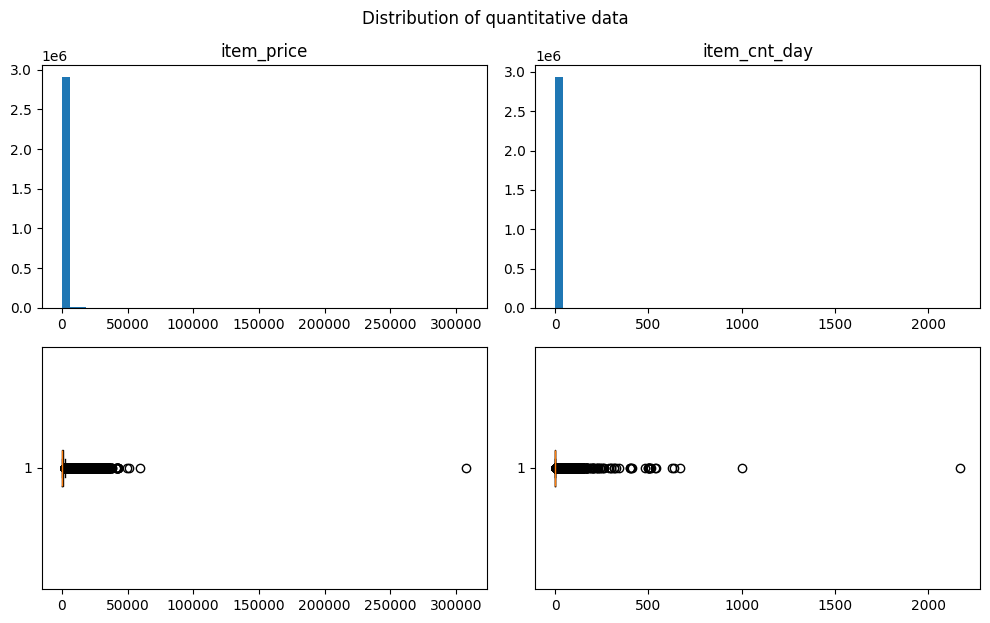

In [98]:
# Distribution of quantitative data
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 6))
ax[0][0].hist(sales_full['item_price'], bins = 50)
ax[0][0].set_title('item_price')
ax[1][0].boxplot(sales_full['item_price'], vert = False)

ax[0][1].hist(sales_full['item_cnt_day'], bins = 50)
ax[0][1].set_title('item_cnt_day')
ax[1][1].boxplot(sales_full['item_cnt_day'], vert = False)

plt.tight_layout()
fig.suptitle('Distribution of quantitative data', y = 1.03)
plt.show()

In [99]:
# Correlation matrix for the quantitative variables
sales_full[['item_price', 'item_cnt_day']].corr()

,item_price,item_cnt_day
item_price,1.000000,0.011841
item_cnt_day,0.011841,1.000000


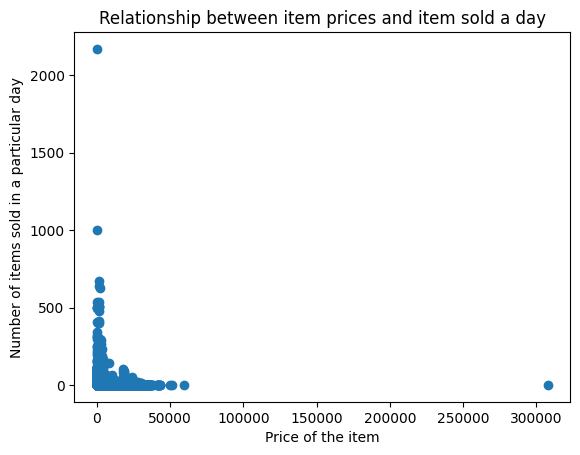

In [100]:
# Visualize the correlation
fig, ax = plt.subplots()
ax.scatter(sales_full['item_price'], sales_full['item_cnt_day'])

ax.set_title('Relationship between item prices and item sold a day')
ax.set_xlabel('Price of the item')
ax.set_ylabel('Number of items sold in a particular day')
plt.show()

#### Removing massive outliers:

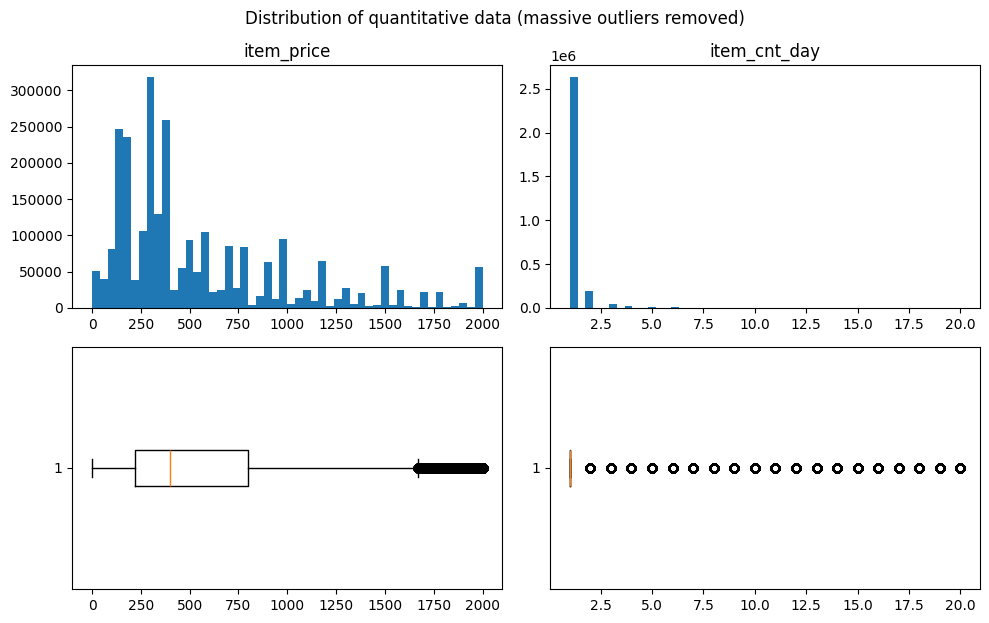

In [101]:
# Remove the outliers and see how the distribution changes
low_prices = sales_full[sales_full['item_price'] <= 2000]
low_cnt_day = sales_full[sales_full['item_cnt_day'] <= 20]

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 6))
ax[0][0].hist(low_prices['item_price'], bins = 50)
ax[0][0].set_title('item_price')
ax[1][0].boxplot(low_prices['item_price'], vert = False)

ax[0][1].hist(low_cnt_day['item_cnt_day'], bins = 50)
ax[0][1].set_title('item_cnt_day')
ax[1][1].boxplot(low_cnt_day['item_cnt_day'], vert = False)

plt.tight_layout()
fig.suptitle('Distribution of quantitative data (massive outliers removed)', y = 1.03)
plt.show()

In [102]:
# Filter for items that had prices of <= 2000 AND item counts per day of <= 20.0
outliers_removed = sales_full[np.logical_and(sales_full['item_price'] <= 2000, sales_full['item_cnt_day'] <= 20)]

# Correlation matrix for the quantitative variables
outliers_removed[['item_price', 'item_cnt_day']].corr()

,item_price,item_cnt_day
item_price,1.000000,-0.007754
item_cnt_day,-0.007754,1.000000


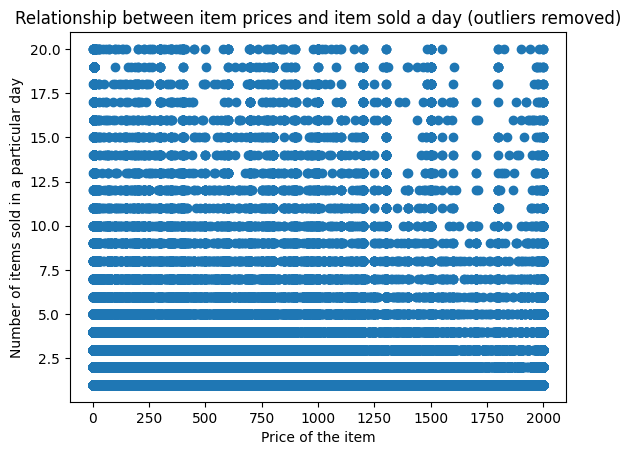

In [103]:
# Visualize the correlation
fig, ax = plt.subplots()
ax.scatter(outliers_removed['item_price'], outliers_removed['item_cnt_day'])

ax.set_title('Relationship between item prices and item sold a day (outliers removed)')
ax.set_xlabel('Price of the item')
ax.set_ylabel('Number of items sold in a particular day')
plt.show()

#### Grouping by month:

In [104]:
sales_full_trunc = sales_full[['month_year', 'item_id', 'item_price', 'item_cnt_day']]
sales_full_trunc = sales_full_trunc.groupby(['month_year', 'item_id', 'item_price'], as_index = False).sum()
sales_full_trunc.rename(columns = {'item_cnt_day': 'item_cnt_month'}, inplace = True)
sales_full_trunc.head()

,month_year,item_id,item_price,item_cnt_month
0,2013-01,19,28.0,1.0
1,2013-01,27,1890.0,2.0
2,2013-01,27,2499.0,5.0
3,2013-01,28,549.0,8.0
4,2013-01,29,1890.0,1.0


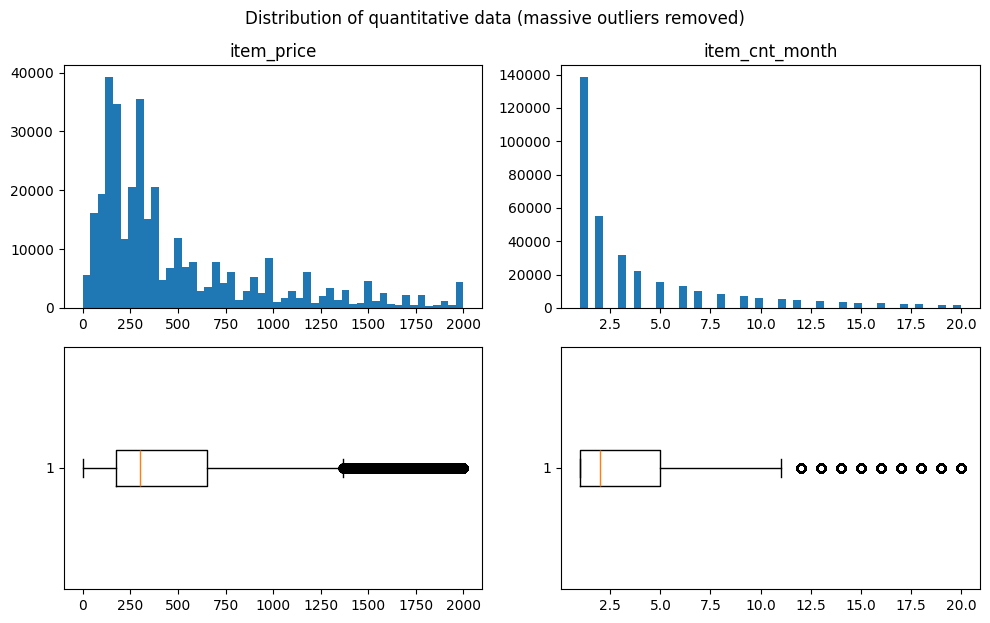

In [105]:
# Outliers removed
low_prices_trunc = sales_full_trunc[sales_full_trunc['item_price'] <= 2000]
low_cnt_month = sales_full_trunc[sales_full_trunc['item_cnt_month'] <= 20] # true target labels are clipped at [0, 20]

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 6))
ax[0][0].hist(low_prices_trunc['item_price'], bins = 50)
ax[0][0].set_title('item_price')
ax[1][0].boxplot(low_prices_trunc['item_price'], vert = False)

ax[0][1].hist(low_cnt_month['item_cnt_month'], bins = 50)
ax[0][1].set_title('item_cnt_month')
ax[1][1].boxplot(low_cnt_month['item_cnt_month'], vert = False)

plt.tight_layout()
fig.suptitle('Distribution of quantitative data (massive outliers removed)', y = 1.03)
plt.show()

In [106]:
# Draw the same correlation matrix (with outliers removed) but grouped by month
outliers_removed_2 = sales_full_trunc[np.logical_and(sales_full_trunc['item_price'] <= 2000, sales_full_trunc['item_cnt_month'] <= 20)]

# Correlation matrix for the quantitative variables
outliers_removed_2[['item_price', 'item_cnt_month']].corr()

,item_price,item_cnt_month
item_price,1.00000,0.01767
item_cnt_month,0.01767,1.00000


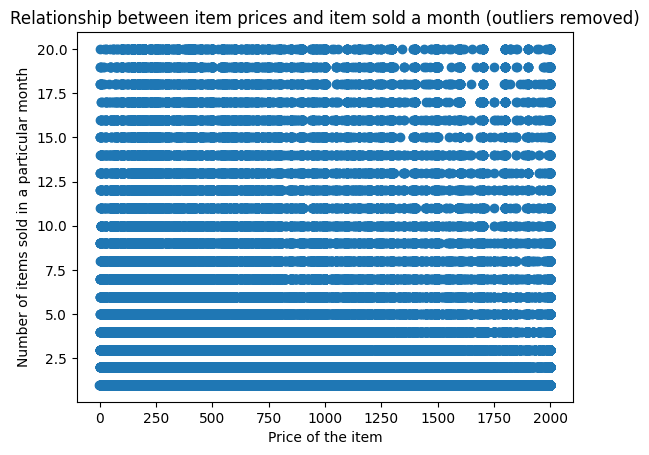

In [107]:
# Visualize the correlation
fig, ax = plt.subplots()
ax.scatter(outliers_removed_2['item_price'], outliers_removed_2['item_cnt_month'])

ax.set_title('Relationship between item prices and item sold a month (outliers removed)')
ax.set_xlabel('Price of the item')
ax.set_ylabel('Number of items sold in a particular month')
plt.show()

### IV. EDA for categorical variables

In [108]:
# Top 10 highest priced item (with names) during 2013-2015
highest_priced = sales_full[['item_id', 'item_name', 'item_price']].copy() # keep only necessary columns
highest_priced.drop_duplicates(subset = ['item_id'], inplace = True) # drop duplicates
highest_priced = highest_priced.sort_values('item_price', ascending = False).iloc[:10] # sort for top 10

highest_priced

,item_id,item_name,item_price
1163158,6066,Radmin 3 - 522 лиц.,307980.0
1488135,13199,Коллекционные шахматы (Властелин Колец),50999.0
2327159,7241,UserGate Proxy & Firewall 6.X с модулем фильтр...,49782.0
2885692,13403,"Комплект ""Microsoft Xbox One 1TB Limited Edit...",42990.0
1006638,7238,UserGate Proxy & Firewall 6.X до 100 сессий,42000.0
2143903,14173,Лицензия 1С-Битрикс: Управление сайтом - Эксперт,40900.0
884848,2410,CorelDRAW Graphics Suite X6 - Small Business E...,36990.0
2890662,13448,Комплект Sony PlayStation 4 (1Tb) Black (CUH-1...,34990.0
2907568,13503,Комплект «Sony PlayStation 4 (1Tb) Black (CUH-...,34990.0
2113,5748,Photoshop 13 Windows Russian BOX,32990.0


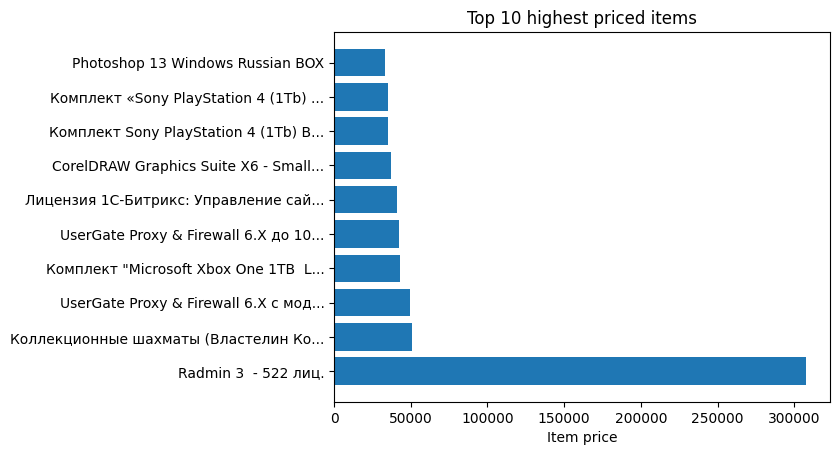

In [109]:
# Truncate item names to 35 characters because many of them are so long
highest_priced['item_name_trunc'] = highest_priced['item_name'].case_when([
    (highest_priced['item_name'].str.len() <= 35, highest_priced['item_name']),
    (highest_priced['item_name'].str.len() > 35, highest_priced['item_name'].str[:35] + "...")
])

fig, ax = plt.subplots()
ax.barh(highest_priced['item_name_trunc'], highest_priced['item_price'])

ax.set_xlabel('Item price')
ax.set_title('Top 10 highest priced items')
plt.show()

In [110]:
# Top 10 items with the most quantity sold
most_sold = sales_full[['item_id', 'item_name', 'item_cnt_day']].copy() # keep only necessary columns
most_sold = most_sold.groupby(['item_id', 'item_name']).sum()
most_sold = most_sold.sort_values('item_cnt_day', ascending = False).iloc[:10] # sort for top 10
most_sold.reset_index(inplace = True)

most_sold

,item_id,item_name,item_cnt_day
0,20949,Фирменный пакет майка 1С Интерес белый (34*42)...,187678.0
1,2808,"Diablo III [PC, Jewel, русская версия]",17265.0
2,3732,"Grand Theft Auto V [PS3, русские субтитры]",16710.0
3,17717,Прием денежных средств для 1С-Онлайн,15830.0
4,5822,Playstation Store пополнение бумажника: Карта ...,14529.0
5,3734,"Grand Theft Auto V [Xbox 360, русские субтитры]",11778.0
6,6675,Sony PlayStation 4 (500 Gb) Black (CUH-1008A/1...,10341.0
7,3731,"Grand Theft Auto V [PC, русские субтитры]",10111.0
8,1855,"Battlefield 4 [PC, русская версия]",10050.0
9,16787,"Одни из нас [PS3, русская версия]",9283.0


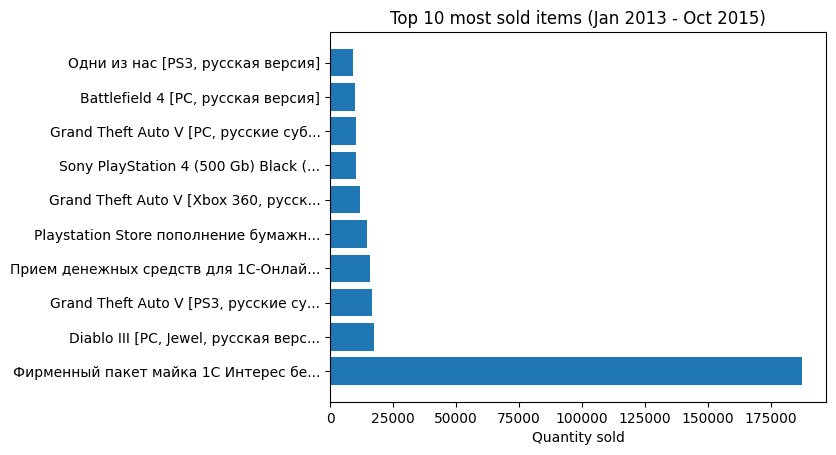

In [111]:
most_sold['item_name_trunc'] = most_sold['item_name'].case_when([
    (most_sold['item_name'].str.len() <= 35, most_sold['item_name']),
    (most_sold['item_name'].str.len() > 35, most_sold['item_name'].str[:35] + "...")
])

fig, ax = plt.subplots()
ax.barh(most_sold['item_name_trunc'], most_sold['item_cnt_day'])

ax.set_xlabel('Quantity sold')
ax.set_title('Top 10 most sold items (Jan 2013 - Oct 2015)')
plt.show()

In [112]:
print(f'Full name of the most sold item: {most_sold.iloc[0, 1]}')

Full name of the most sold item: Фирменный пакет майка 1С Интерес белый (34*42) 45 мкм


In [113]:
# Item category with highest median price
cat_highest_medprice = sales_full[['item_category_id', 'item_category_name', 'item_price']].copy() # keep only necessary columns

# Summarize median price of different item categories
cat_highest_medprice = cat_highest_medprice.groupby(['item_category_id', 'item_category_name']).median()
# Sort the median prices in descending order and keep the top 10
cat_highest_medprice = cat_highest_medprice.sort_values('item_price', ascending = False).iloc[:10]

cat_highest_medprice.reset_index(inplace = True)
cat_highest_medprice

,item_category_id,item_category_name,item_price
0,12,Игровые консоли - PS4,22990.0
1,16,Игровые консоли - XBOX ONE,20499.0
2,11,Игровые консоли - PS3,13490.0
3,15,Игровые консоли - XBOX 360,11491.0
4,14,Игровые консоли - PSVita,9490.0
5,13,Игровые консоли - PSP,4589.4
6,7,Аксессуары - XBOX ONE,2840.0
7,20,Игры - PS4,2799.0
8,74,Программы - MAC (Цифра),2780.0
9,2,Аксессуары - PS3,2390.0


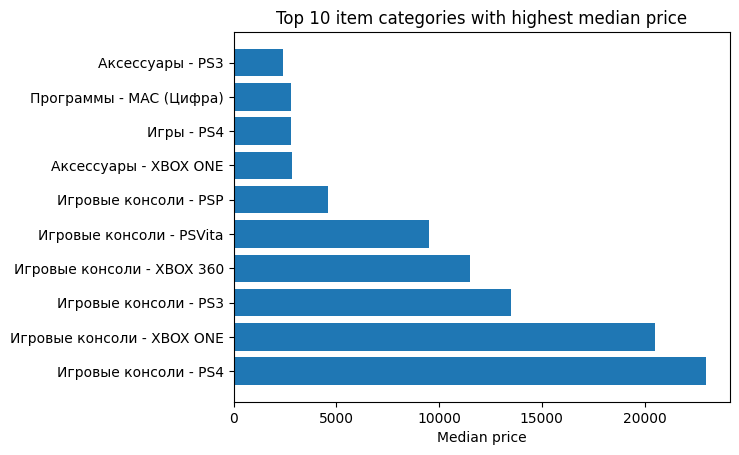

In [114]:
fig, ax = plt.subplots()
ax.barh(cat_highest_medprice['item_category_name'], cat_highest_medprice['item_price'])

ax.set_xlabel('Median price')
ax.set_title('Top 10 item categories with highest median price')
plt.show()

In [115]:
# Top 10 item categories with the most quantity sold
cat_most_sold = sales_full[['item_category_id', 'item_category_name', 'item_cnt_day']].copy()
cat_most_sold = cat_most_sold.groupby(['item_category_id', 'item_category_name']).sum()
cat_most_sold = cat_most_sold.sort_values('item_cnt_day', ascending = False).iloc[:10]
cat_most_sold.reset_index(inplace = True)

cat_most_sold

,item_category_id,item_category_name,item_cnt_day
0,40,Кино - DVD,635599.0
1,30,Игры PC - Стандартные издания,458178.0
2,55,Музыка - CD локального производства,349509.0
3,19,Игры - PS3,256627.0
4,37,Кино - Blu-Ray,204778.0
5,71,"Подарки - Сумки, Альбомы, Коврики д/мыши",188034.0
6,28,Игры PC - Дополнительные издания,175500.0
7,23,Игры - XBOX 360,171210.0
8,20,Игры - PS4,128207.0
9,65,Подарки - Настольные игры (компактные),73129.0


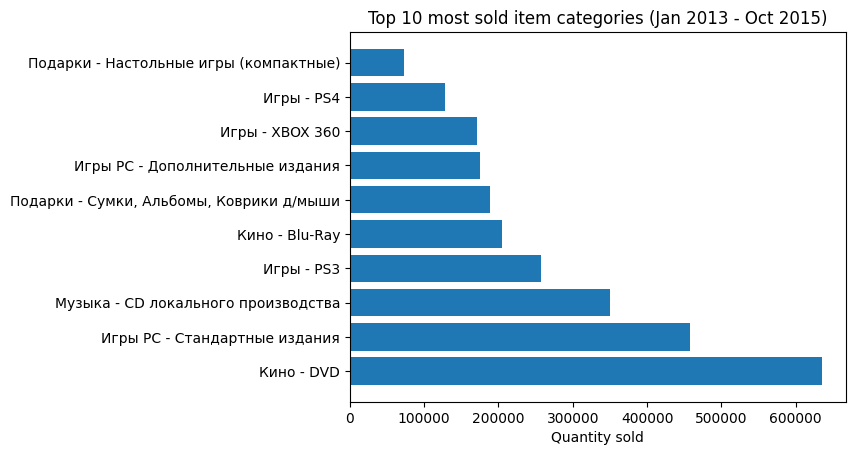

In [116]:
fig, ax = plt.subplots()
ax.barh(cat_most_sold['item_category_name'], cat_most_sold['item_cnt_day'])

ax.set_xlabel('Quantity sold')
ax.set_title('Top 10 most sold item categories (Jan 2013 - Oct 2015)')
plt.show()

In [117]:
# Top 10 shops with the most quantity sold
shop_most_sold = sales_full[['shop_id', 'shop_name', 'item_cnt_day']].copy()
shop_most_sold = shop_most_sold.groupby(['shop_id', 'shop_name']).sum()
shop_most_sold = shop_most_sold.sort_values('item_cnt_day', ascending = False).iloc[:10]
shop_most_sold.reset_index(inplace = True)

shop_most_sold

,shop_id,shop_name,item_cnt_day
0,31,"Москва ТЦ ""Семеновский""",311683.0
1,25,"Москва ТРК ""Атриум""",242554.0
2,54,"Химки ТЦ ""Мега""",186508.0
3,28,"Москва ТЦ ""МЕГА Теплый Стан"" II",184997.0
4,42,"СПб ТК ""Невский Центр""",145456.0
5,57,"Якутск Орджоникидзе, 56",141741.0
6,27,"Москва ТЦ ""МЕГА Белая Дача II""",136973.0
7,6,"Воронеж (Плехановская, 13)",101025.0
8,58,"Якутск ТЦ ""Центральный""",82082.0
9,46,"Сергиев Посад ТЦ ""7Я""",79194.0


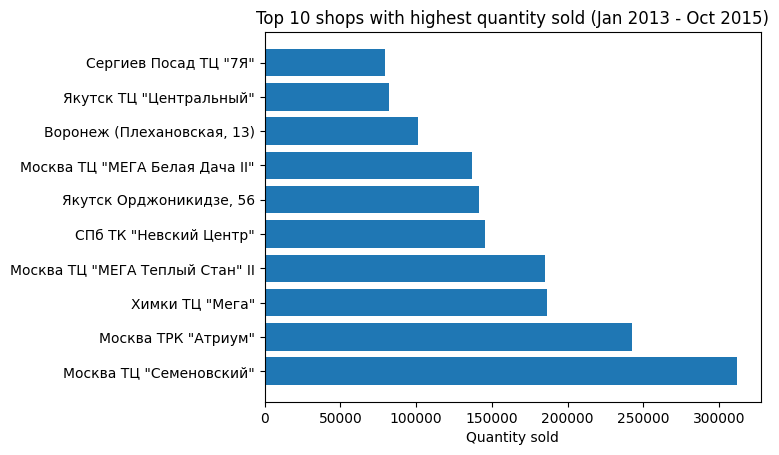

In [118]:
fig, ax = plt.subplots()
ax.barh(shop_most_sold['shop_name'], shop_most_sold['item_cnt_day'])

ax.set_xlabel('Quantity sold')
ax.set_title('Top 10 shops with highest quantity sold (Jan 2013 - Oct 2015)')
plt.show()

### V. Adding the time series element

In [119]:
# https://blog.finxter.com/5-effective-ways-to-check-missing-dates-in-pandas/
# https://stackoverflow.com/questions/18176933/create-an-empty-data-frame-with-index-from-another-data-frame

# What date is missing?
# Extract only the dates in the data of sales recorded (sales_dates)
sales_dates = sales_full[['date']].copy()
sales_dates.drop_duplicates(inplace = True)

# Create a DataFrame containing all possible dates within the "min sale date" and "max sale date" (full_dates)
dates_indexer = pd.date_range(start = min(sales_dates['date']), end = max(sales_dates['date'])) # returns a DateTime index
full_dates = pd.DataFrame(index = dates_indexer)
full_dates.reset_index(inplace = True) # for better merging

# Now join full_dates with sales_dates to check if there is any NaT values
check_dates = full_dates.merge(sales_dates, left_on = 'index', right_on = 'date', how = 'left')
check_dates.head()

,index,date
0,2013-01-01,2013-01-01
1,2013-01-02,2013-01-02
2,2013-01-03,2013-01-03
3,2013-01-04,2013-01-04
4,2013-01-05,2013-01-05


In [120]:
check_dates.isna().sum()

index    0
date     0
dtype: int64

All possible dates between the "min sale date" and "max sale date" has a record in the sales dataset.

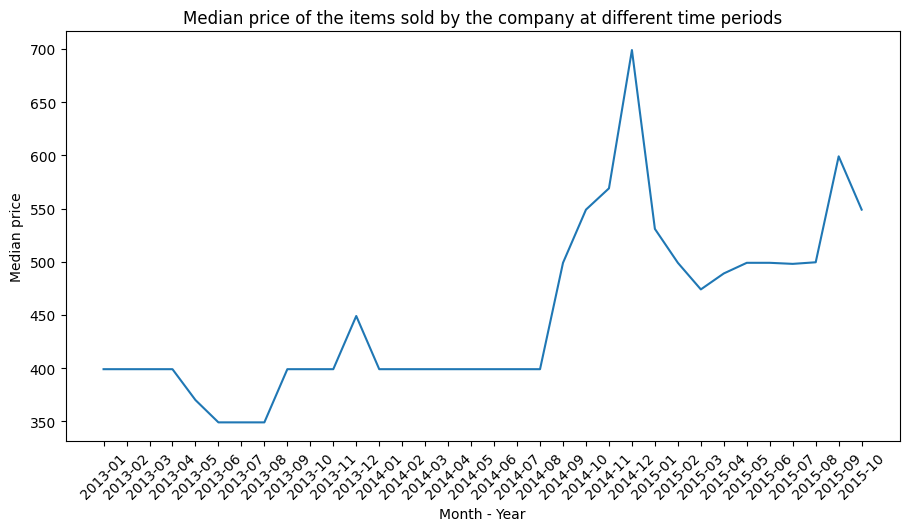

In [121]:
# Median price over time
price_over_my = sales_full[['month_year', 'item_price']].copy()
price_over_my = price_over_my.groupby('month_year').median()
price_over_my.reset_index(inplace = True)

fig, ax = plt.subplots(figsize = (9, 5))
ax.plot(price_over_my['month_year'], price_over_my['item_price'])
ax.tick_params(axis = 'x', labelrotation = 45)
plt.tight_layout()

ax.set_xlabel('Month - Year')
ax.set_ylabel('Median price')
ax.set_title('Median price of the items sold by the company at different time periods')
plt.show()

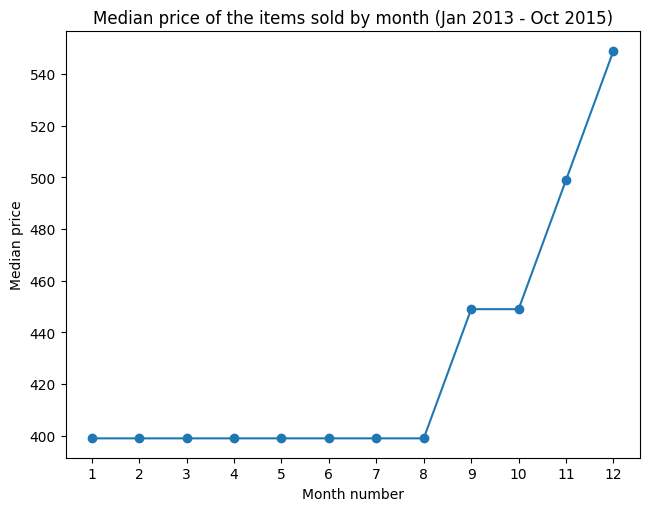

In [122]:
# Median price over months of the year
price_over_my = sales_full[['month', 'item_price']].copy()
price_over_my = price_over_my.groupby('month').median()
price_over_my.reset_index(inplace = True)

fig, ax = plt.subplots()
ax.plot(price_over_my['month'], price_over_my['item_price'], marker = 'o')
plt.tight_layout()

ax.set_xticks(range(1, 13, 1))
ax.set_xlabel('Month number')
ax.set_ylabel('Median price')
ax.set_title('Median price of the items sold by month (Jan 2013 - Oct 2015)')
plt.show()

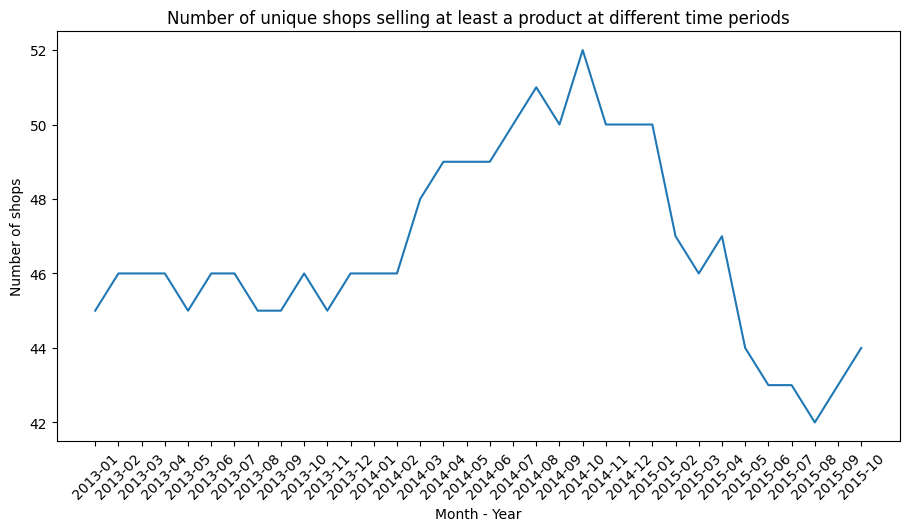

In [123]:
# Count number of distinct shops by month-year pair
shop_count_my = sales_full[['month_year', 'shop_id']].groupby('month_year').nunique()
# .nunique() to denote that we only care about the number of distinct shops
shop_count_my = shop_count_my.reset_index()
# Move the month-year outside the index for more convenient plotting

fig, ax = plt.subplots(figsize = (9, 5))
ax.plot(shop_count_my['month_year'], shop_count_my['shop_id'])
ax.tick_params(axis = 'x', labelrotation = 45)
plt.tight_layout()

ax.set_xlabel('Month - Year')
ax.set_ylabel('Number of shops')
ax.set_title('Number of unique shops selling at least a product at different time periods')
plt.show()

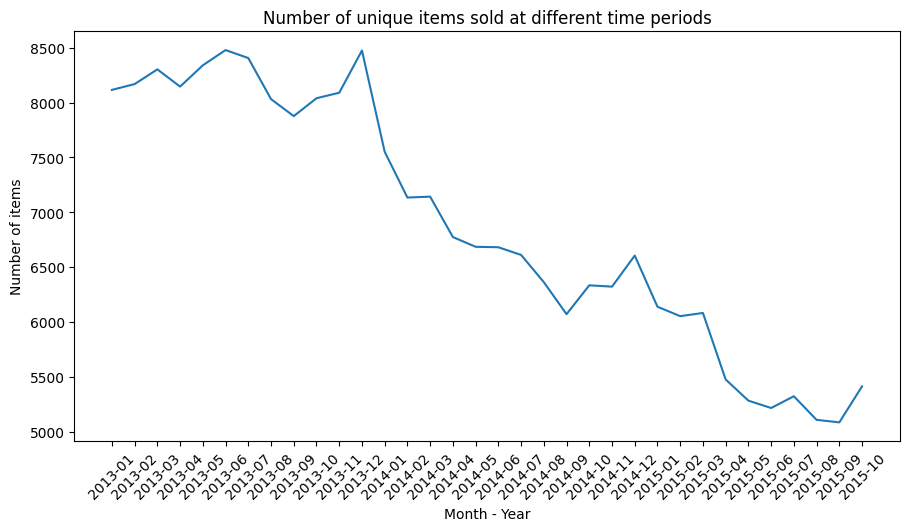

In [47]:
# Count number of distinct shops by month-year pair
item_count_my = sales_full[['month_year', 'item_id']].groupby('month_year').nunique()
# .nunique() to denote that we only care about the number of distinct shops
item_count_my = item_count_my.reset_index()
# Move the month-year outside the index for more convenient plotting

fig, ax = plt.subplots(figsize = (9, 5))
ax.plot(item_count_my['month_year'], item_count_my['item_id'])
ax.tick_params(axis = 'x', labelrotation = 45)
plt.tight_layout()

ax.set_xlabel('Month - Year')
ax.set_ylabel('Number of items')
ax.set_title('Number of unique items sold at different time periods')
plt.show()

### VI. More complicated analysis with grouping time series:

In [144]:
# Number of unique items and shops that the company has sold
print(f'Number of unique items: {sales_full['item_id'].nunique()}')
print(f'Number of unique shops: {sales_full['shop_id'].nunique()}')

Number of unique items: 21807
Number of unique shops: 60


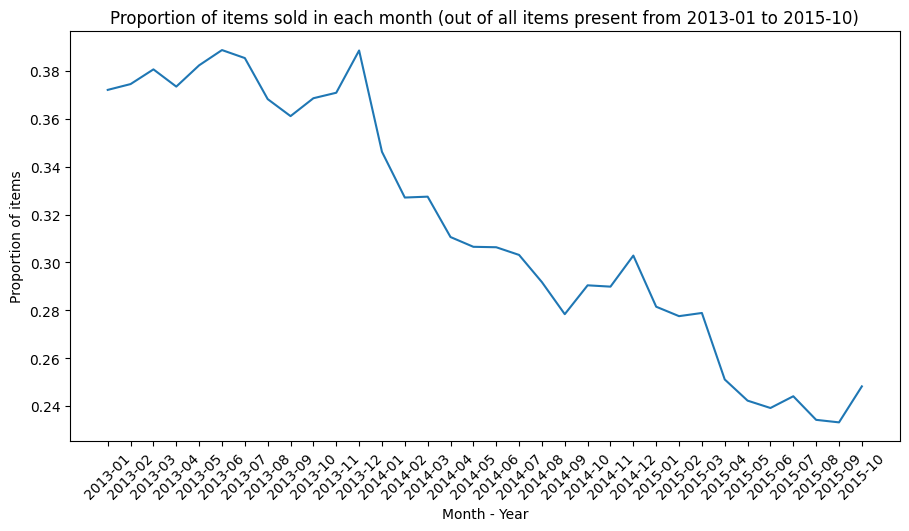

In [149]:
# Proportion of items sold in each month
item_pct_month = sales_full[['month_year', 'item_id']]
item_pct_month = item_pct_month.groupby('month_year', as_index = False).nunique()
item_pct_month['item_id'] = item_pct_month['item_id'] / sales_full['item_id'].nunique()

fig, ax = plt.subplots(figsize = (9, 5))
ax.plot(item_pct_month['month_year'], item_pct_month['item_id'])
ax.tick_params(axis = 'x', labelrotation = 45)
plt.tight_layout()

ax.set_xlabel('Month - Year')
ax.set_ylabel('Proportion of items')
ax.set_title('Proportion of items sold in each month (out of all items present from 2013-01 to 2015-10)')
plt.show()

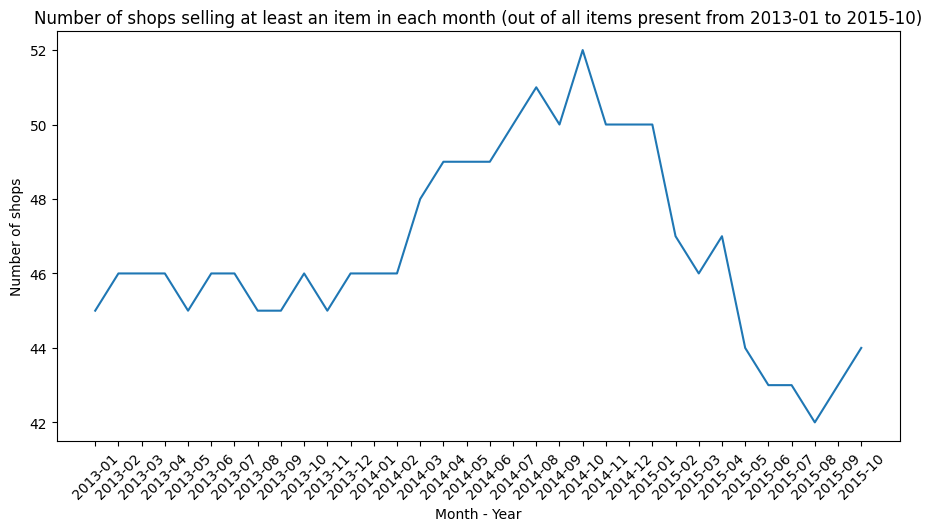

In [147]:
# Percentage of shops sold in each month
shop_pct_month = sales_full[['month_year', 'shop_id']]
shop_pct_month = shop_pct_month.groupby('month_year', as_index = False).nunique()
shop_pct_month['shop_id'] = shop_pct_month['shop_id']

fig, ax = plt.subplots(figsize = (9, 5))
ax.plot(shop_pct_month['month_year'], shop_pct_month['shop_id'])
ax.tick_params(axis = 'x', labelrotation = 45)
plt.tight_layout()

ax.set_xlabel('Month - Year')
ax.set_ylabel('Number of shops')
ax.set_title('Number of shops selling at least an item in each month (out of all items present from 2013-01 to 2015-10)')
plt.show()

In [155]:
sales_datetime = sales_full[['date', 'date_block_num', 'month_year', 'shop_id', 'item_id', 'item_price', 'item_cnt_day']].copy()
sales_datetime.sort_values(['date', 'shop_id', 'item_id'], inplace = True, ignore_index = True)
sales_datetime.head()

,date,date_block_num,month_year,shop_id,item_id,item_price,item_cnt_day
0,2013-01-01,0,2013-01,2,991,99.0,1.0
1,2013-01-01,0,2013-01,2,1472,2599.0,1.0
2,2013-01-01,0,2013-01,2,1905,249.0,1.0
3,2013-01-01,0,2013-01,2,2920,599.0,2.0
4,2013-01-01,0,2013-01,2,3320,1999.0,1.0


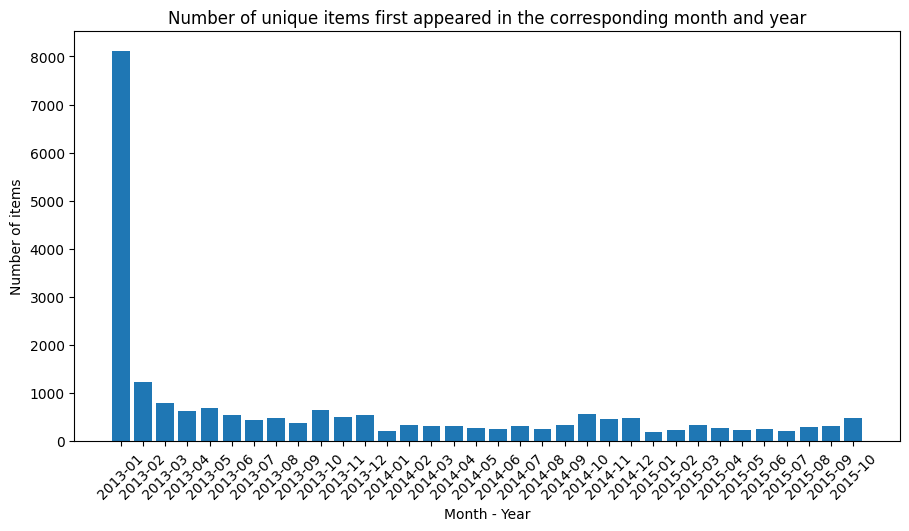

In [163]:
# First appearance of each item_id in the data?
first_item_appearance = sales_datetime.drop_duplicates(subset = ['item_id'], ignore_index = True)
first_item_appearance = first_item_appearance[['month_year', 'item_id']].groupby('month_year', as_index = False).count()

fig, ax = plt.subplots(figsize = (9, 5))
ax.bar(first_item_appearance['month_year'], first_item_appearance['item_id'])
ax.tick_params(axis = 'x', labelrotation = 45)
plt.tight_layout()

ax.set_xlabel('Month - Year')
ax.set_ylabel('Number of items')
ax.set_title('Number of unique items first appeared in the corresponding month and year')
plt.show()

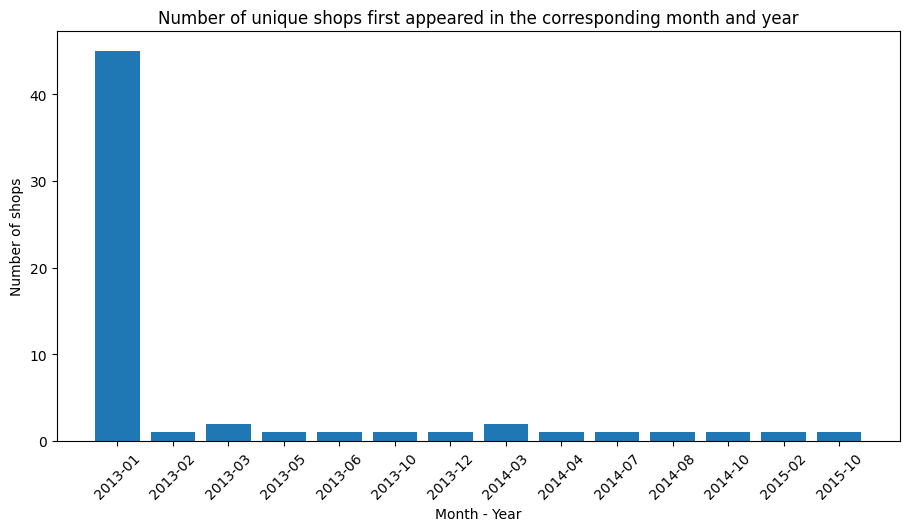

In [165]:
# First appearance of each shop_id in the data?
first_item_appearance = sales_datetime.drop_duplicates(subset = ['shop_id'], ignore_index = True)
first_item_appearance = first_item_appearance[['month_year', 'shop_id']].groupby('month_year', as_index = False).count()

fig, ax = plt.subplots(figsize = (9, 5))
ax.bar(first_item_appearance['month_year'], first_item_appearance['shop_id'])
ax.tick_params(axis = 'x', labelrotation = 45)
plt.tight_layout()

ax.set_xlabel('Month - Year')
ax.set_ylabel('Number of shops')
ax.set_title('Number of unique shops first appeared in the corresponding month and year')
plt.show()

### VII. Test on different models

- https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html

- https://machinelearningcoban.com/tabml_book/ch_data_processing/hashing.html

- https://www.kaggle.com/code/avanwyk/encoding-cyclical-features-for-deep-learning

In [48]:
# Set seed for reproducibility
my_seed = 275225

In [49]:
# Check data types again
sales_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 10 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         category      
 3   item_id         category      
 4   item_price      float64       
 5   item_cnt_day    float64       
 6   year            int32         
 7   month           int32         
 8   day             int32         
 9   month_year      object        
dtypes: category(2), datetime64[ns](1), float64(2), int32(3), int64(1), object(1)
memory usage: 154.7+ MB


In [50]:
# Does item price for each (shop_id, item_id) pair vary by month?
price_check = sales_full[['month_year', 'shop_id', 'item_id', 'item_price']].copy() # keep the necessary columns

# Check if there are rows with the same month_year, shop_id, item_id but different item_price
price_check.drop_duplicates(subset = ['month_year', 'shop_id', 'item_id'], inplace = True)
print(f'Number of duplicated prices: {price_check.duplicated().sum()}')

Number of duplicated prices: 0


In [51]:
# Group sales_train by month
sales_train_org = sales_train[['month_year', 'shop_id', 'item_id', 'item_price', 'item_cnt_day']].copy() # keep necessary columns only
sales_train_org['month_year'] = pd.to_datetime(sales_train_org['month_year'], format = '%Y-%m') # change to datetime format

# Set the data in correct order
sales_train_org.sort_values(['month_year', 'shop_id', 'item_id'], inplace = True)

# Take the total of daily sales to get monthly sales
sales_train_org = sales_train_org.groupby(['month_year', 'shop_id', 'item_id'], observed = True)\
    .agg({'item_price': 'median', 'item_cnt_day': 'sum'})

# Changing column name to fit with the sample submission data
sales_train_org.reset_index(inplace = True)
sales_train_org = sales_train_org.rename(columns = {'item_cnt_day': 'item_cnt_month'})

sales_train_org.head()

,month_year,shop_id,item_id,item_price,item_cnt_month
0,2013-01-01,0,32,221.0,6.0
1,2013-01-01,0,33,347.0,3.0
2,2013-01-01,0,35,247.0,1.0
3,2013-01-01,0,43,221.0,1.0
4,2013-01-01,0,51,128.5,2.0


We have some unnecessary ```(shop_id, item_id)``` pairs that do not appear in the test set. For the sake of submitting predictions to the corresponding Kaggle competition, it is best to drop these unnecessary pairs together to reduce model complexity and improved computing time.

In [52]:
# Filter out the (shop_id, item_id) pairs not mentioned in the test set
sales_train_org = test.merge(sales_train_org, how = 'left', on = ['shop_id', 'item_id'])

# Remove the ID column
sales_train_org.drop('ID', axis = 1, inplace = True)

print(sales_train_org.shape)
sales_train_org.tail()

(702955, 5)


,shop_id,item_id,month_year,item_price,item_cnt_month
702950,45,15757,2015-02-01,199.0,1.0
702951,45,19648,NaT,NaN,NaN
702952,45,969,2014-06-01,549.0,3.0
702953,45,969,2014-07-01,549.0,1.0
702954,45,969,2014-08-01,549.0,1.0


A Kaggle discussion forum: https://www.kaggle.com/competitions/competitive-data-science-predict-future-sales/discussion/559492

> "Also, note that there are ~350 new items (never appeared in train, but appear in test)."

In [53]:
# Count null values
sales_train_org.isnull().sum()

shop_id                0
item_id                0
month_year        102796
item_price        102796
item_cnt_month    102796
dtype: int64

In [54]:
# Impute the missing values with a constant
sales_train_org['month_year'] = sales_train_org['month_year'].fillna(pd.Timestamp('2015-10-01'))
sales_train_org['item_cnt_month'] = sales_train_org['item_cnt_month'].fillna(0)

# Impute the item_price with the median prices
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy = 'median')
imputed_prices = imp.fit_transform(sales_train_org[['item_price']])
sales_train_org['item_price'] = imputed_prices

sales_train_org.tail()

,shop_id,item_id,month_year,item_price,item_cnt_month
702950,45,15757,2015-02-01,199.0,1.0
702951,45,19648,2015-10-01,474.0,0.0
702952,45,969,2014-06-01,549.0,3.0
702953,45,969,2014-07-01,549.0,1.0
702954,45,969,2014-08-01,549.0,1.0


In [55]:
# Check for duplicates
sales_train_org.duplicated().sum()

np.int64(0)

In [56]:
# Split the month_year data into 2 separate month and year columns
sales_train_org['year'] = sales_train_org['month_year'].dt.year
sales_train_org['month'] = sales_train_org['month_year'].dt.month

sales_train_org.head()

,shop_id,item_id,month_year,item_price,item_cnt_month,year,month
0,5,5037,2014-09-01,2599.0,1.0,2014,9
1,5,5037,2014-11-01,2599.0,1.0,2014,11
2,5,5037,2014-12-01,1999.0,2.0,2014,12
3,5,5037,2015-01-01,1999.0,2.0,2015,1
4,5,5037,2015-05-01,1299.0,1.0,2015,5


In [57]:
# Encode month using trigonometric encoding for cyclical features
sales_train_month = sales_train_org.copy()

sales_train_month['month_sin'] = np.sin(sales_train_month['month'] / 12 * 2 * np.pi)
sales_train_month['month_cos'] = np.cos(sales_train_month['month'] / 12 * 2 * np.pi)

# Keep the necessary columns only
sales_train_month = sales_train_month[['year', 'month_sin', 'month_cos', 'shop_id', 'item_id', 'item_price', 'item_cnt_month']]
print(sales_train_month.shape)
sales_train_month.head()

(702955, 7)


,year,month_sin,month_cos,shop_id,item_id,item_price,item_cnt_month
0,2014,-1.000000e+00,-1.836970e-16,5,5037,2599.0,1.0
1,2014,-5.000000e-01,8.660254e-01,5,5037,2599.0,1.0
2,2014,-2.449294e-16,1.000000e+00,5,5037,1999.0,2.0
3,2015,5.000000e-01,8.660254e-01,5,5037,1999.0,2.0
4,2015,5.000000e-01,-8.660254e-01,5,5037,1299.0,1.0


In [58]:
# Target encoding for the shop_id and item_id data
# Scale columns with MinMaxScaler (except for month_sin and month_cos already encoded and scaled)

from sklearn.preprocessing import TargetEncoder
from sklearn.compose import ColumnTransformer

# Encode the categorical variables with high cardinality (having many unique values)
# We typically don't apply any encoder to columns already encoded

transformer = ColumnTransformer(transformers = [('target_enc', TargetEncoder(target_type = 'continuous', random_state = my_seed), ['shop_id', 'item_id'])],
                                remainder = 'passthrough')

In [59]:
# Declare features and targets
X_month = sales_train_month[['year', 'month_sin', 'month_cos', 'shop_id', 'item_id', 'item_price']]
y_month = sales_train_month[['item_cnt_month']]

transformed_X = transformer.fit_transform(X_month, y_month.values.ravel())
print(transformed_X.shape)
# sklearn requires y as a 1D array, so I need to use .ravel()

# Get column names
# Inspired by: https://www.kaggle.com/code/eprossinger/linear-regression-with-columntransformer
sales_train_month_enc = pd.DataFrame(np.concatenate((transformed_X, y_month), axis = 1), columns = sales_train_month.columns.tolist())
sales_train_month_enc.head()

(702955, 6)


,year,month_sin,month_cos,shop_id,item_id,item_price,item_cnt_month
0,1.715006,2.757028,2014.0,-1.000000e+00,-1.836970e-16,2599.0,1.0
1,1.701273,2.953040,2014.0,-5.000000e-01,8.660254e-01,2599.0,1.0
2,1.715006,2.757028,2014.0,-2.449294e-16,1.000000e+00,1999.0,2.0
3,1.715006,2.757028,2015.0,5.000000e-01,8.660254e-01,1999.0,2.0
4,1.701273,2.953040,2015.0,5.000000e-01,-8.660254e-01,1299.0,1.0


In [60]:
from sklearn.model_selection import TimeSeriesSplit

# Declare X and y again
X_train = sales_train_month.drop('item_cnt_month', axis = 1).values
y_train = sales_train_month[['item_cnt_month']].values.ravel()

# Split the data into train and validation sets; taking into account the consideration of time
ts = TimeSeriesSplit(n_splits = 5, max_train_size = 700000, test_size = 75000)

In [61]:
for i, (train_indices, val_indices) in enumerate(ts.split(X_train, y_train)):
    print('--------------------------------------------------------------------')
    print(f'Fold {i + 1}:')
    print(f'Training indices: {train_indices[0]} -> {train_indices[-1]}, validation indices: {val_indices[0]} -> {val_indices[-1]}')
    print(f'Training data: {len(train_indices)} examples, validation data: {len(val_indices)} examples')
    print(f'Ratio of validation to training data: {round((len(val_indices) / len(train_indices)), 5)}')

--------------------------------------------------------------------
Fold 1:
Training indices: 0 -> 327954, validation indices: 327955 -> 402954
Training data: 327955 examples, validation data: 75000 examples
Ratio of validation to training data: 0.22869
--------------------------------------------------------------------
Fold 2:
Training indices: 0 -> 402954, validation indices: 402955 -> 477954
Training data: 402955 examples, validation data: 75000 examples
Ratio of validation to training data: 0.18613
--------------------------------------------------------------------
Fold 3:
Training indices: 0 -> 477954, validation indices: 477955 -> 552954
Training data: 477955 examples, validation data: 75000 examples
Ratio of validation to training data: 0.15692
--------------------------------------------------------------------
Fold 4:
Training indices: 0 -> 552954, validation indices: 552955 -> 627954
Training data: 552955 examples, validation data: 75000 examples
Ratio of validation to tra

In [62]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

# Linear models
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor

# Tree-based models, including ensembles
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor,\
    HistGradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

# Some other less-used regression models (may use them soon)
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.neural_network import MLPRegressor

import time # I want to measure the efficiency of different machine learning models

Because the result of trigonometric scaling is from -1 to 1, I will use ```MinMaxScaler``` for the remaining numerical variables, which also shares the scale from -1 to 1.

In [63]:
def train_model(model_name, model):

    # Initialize the data
    mean_rmse = []
    std_rmse = []
    execution_time = []

    # Pipeline: Scaling and predicting in each fold
    pipe = Pipeline([('minmax_scaler',  MinMaxScaler(feature_range = (-1, 1))),
                    ('regression', model)])
    
    # I want to measure time that Python fits the data and output the cross-validation scores list
    start_time = time.perf_counter()
    pipe.fit(X_train, y_train)
        
    # Calculate cross-validation score (mean and standard deviation of RMSEs)
    # Note that cross_val_score only has negative RMSE
    score_list = np.array(cross_val_score(pipe, X_train, y_train, scoring = 'neg_root_mean_squared_error', cv = ts)) * (-1)
    end_time = time.perf_counter()

    # Append the necessary metrics to the list
    mean_rmse.append(np.mean(score_list))
    std_rmse.append(np.std(score_list))
    execution_time.append(end_time - start_time)

    # Return the result as a DataFrame
    # The execution time is measured in seconds
    df = pd.DataFrame({'model_name': model_name, 'mean_rmse': mean_rmse, 'std_rmse': std_rmse, 'execution_time': execution_time})
    return df

In [64]:
import re
import warnings
warnings.filterwarnings(action = 'ignore', message = r'^X does not have valid feature names')

In [ ]:
# WARNING: THIS CODE BLOCK WILL TAKE A LONG TIME TO RUN (est. 30 mins)

model_list = [('Linear Regression', LinearRegression(n_jobs = -1)),
              ('Lasso', Lasso(random_state = my_seed)),
              ('Ridge', Ridge(random_state = my_seed)),
              ('Elastic Net', ElasticNet(random_state = my_seed)),
              ('Decision Tree', DecisionTreeRegressor(random_state = my_seed)),
              ('Random Forest', RandomForestRegressor(n_jobs = -1, random_state = my_seed)),
              ('AdaBoost', AdaBoostRegressor(random_state = my_seed)),
              ('Gradient Boosting', GradientBoostingRegressor(random_state = my_seed)),
              ('Hist-based Gradient Boosting', HistGradientBoostingRegressor(random_state = my_seed)),
              ('XGBoost', XGBRegressor(n_jobs = -1, random_state = my_seed)),
              ('CatBoost', CatBoostRegressor(random_state = my_seed, verbose = False)),
              ('LightGBM', LGBMRegressor(n_jobs = -1, random_state = my_seed, verbose = -1))]

overall_results = pd.concat([train_model(model_name, model) for model_name, model in model_list], axis = 0, ignore_index = True)
overall_results.sort_values(['mean_rmse', 'std_rmse', 'execution_time'], inplace = True, ignore_index = True)
overall_results

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008867 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 577
[LightGBM] [Info] Number of data points in the train set: 702955, number of used features: 6
[LightGBM] [Info] Start training from score 2.309996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003558 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 553
[LightGBM] [Info] Number of data points in the train set: 327955, number of used features: 6
[LightGBM] [Info] Start training from score 2.637770
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002595 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

,model_name,mean_rmse,std_rmse,execution_time
0,Elastic Net,6.846773,1.867288,5.398457
1,Lasso,6.849421,1.867147,5.313485
2,Ridge,6.855140,1.869863,5.081757
3,Linear Regression,6.855143,1.869861,6.035778
4,Gradient Boosting,8.464195,3.671592,309.549987
5,Hist-based Gradient Boosting,9.587067,4.451536,14.673715
6,LightGBM,9.807892,4.641305,4.813010
7,CatBoost,10.362055,4.861870,210.914617
8,Random Forest,10.887544,4.996105,615.495692
9,Decision Tree,11.819205,5.231270,42.084809


### VIII. Hyperparameter tuning

In [65]:
import optuna
from optuna.samplers import TPESampler

In [66]:
# Tuning for ElasticNet
def objective_elasticnet(trial):
    alpha = trial.suggest_float('alpha', 10**(-3), 10**2, log = True)
    l1_ratio = trial.suggest_float('l1_ratio', 0.05, 0.95, step = 0.05)
    tol = trial.suggest_float('tol', 10**(-5), 10**(-2), log = True)

    # Increase max_iter to 10000 for better results
    elasticnet_tuned = ElasticNet(random_state = my_seed, max_iter = 10000, alpha = alpha,
                                  l1_ratio = l1_ratio, tol = tol)

    pipe = Pipeline([('minmax_scaler',  MinMaxScaler(feature_range = (-1, 1))),
                    ('regression', elasticnet_tuned)])

    try:
        crossval_list = cross_val_score(pipe, X_train, y_train, scoring = 'neg_root_mean_squared_error', cv = ts, n_jobs = -1)

        if trial.should_prune():
            raise optuna.TrialPruned()
    
        return np.mean(crossval_list) * (-1) # this will return the correct RMSE in the cross_val_score
    
    except Exception:
        pass

    # Use the try-except syntax to make sure the study does not end when a trial fails 

In [ ]:
# WARNING: THIS CODE BLOCK WILL TAKE A LONG TIME TO RUN (est. 1 hour)

# https://optuna.readthedocs.io/en/stable/reference/generated/optuna.pruners.MedianPruner.html
# Use MedianPruner as a form of early stopping
study = optuna.create_study(sampler = TPESampler(seed = my_seed), direction = 'minimize',
    pruner = optuna.pruners.MedianPruner(n_startup_trials = 3, n_warmup_steps = 1, interval_steps = 1, n_min_trials = 1))

# Not printing out Optuna updates periodically, including failed trials
optuna.logging.set_verbosity(optuna.logging.ERROR)
study.optimize(objective_elasticnet, n_trials = 1000)

# https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.FrozenTrial.html
elasticnet_best_params = study.best_trial.params

print(f'Trial number {study.best_trial.number} has the best performance, with a score of {study.best_trial.value}.')
print(f'The best parameters are: {study.best_trial.params}')

[I 2025-07-31 10:04:32,412] A new study created in memory with name: no-name-e5bca096-9531-4d2b-86f6-e5e4ee4d3f21


Trial number 244 has the best performance, with a score of 6.820735420420165.
The best parameters are: {'alpha': 0.23851503552998943, 'l1_ratio': 0.95, 'tol': 0.0006029344710928411}


In [ ]:
# Check the hyperparameter tuning result of Optuna with the test set (Optuna with 1000 trials)
elasticnet_tuned = ElasticNet(random_state = my_seed, max_iter = 10000, **elasticnet_best_params)
train_model('ElasticNet (Tuned)', elasticnet_tuned)

,model_name,mean_rmse,std_rmse,execution_time
0,ElasticNet (Tuned),6.820735,1.876767,2.078898


In [67]:
# Tuning for LightGBM
# https://medium.com/@amitsinghrajput_92567/understanding-hyperparameters-in-decision-trees-xgboost-and-lightgbm-7b64cfed77f0

def objective_lgbm(trial):
    num_leaves = trial.suggest_int('num_leaves', 5, 100, step = 1)
    max_depth = trial.suggest_int('max_depth', 5, 100, step = 1)
    learning_rate = trial.suggest_float('learning_rate', 10**(-4), 10**(-1), log = True)
    min_split_gain = trial.suggest_float('min_split_gain', 0.05, 0.95, step = 0.05)
    min_child_weight = trial.suggest_float('min_child_weight', 10**(-4), 10**1, log = True)
    min_child_samples = trial.suggest_int('min_child_samples', 10, 10000, log = True)
    subsample = trial.suggest_float('subsample', 0.05, 0.95, step = 0.05)
    subsample_freq = trial.suggest_int('subsample_freq', 10, 1000, log = True)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.05, 0.95, step = 0.05)
    reg_alpha = trial.suggest_float('reg_alpha', 10**(-3), 10**1, log = True)
    reg_lambda = trial.suggest_float('reg_lambda', 10**(-3), 10**1, log = True)

    # Set n_estimators = 10000, random_state, verbose, and n_jobs to preferred value
    lgbm_tuned = LGBMRegressor(n_estimators = 10000, random_state = my_seed, n_jobs = -1, verbose = -1,
                               num_leaves = num_leaves, max_depth = max_depth, learning_rate = learning_rate,
                               min_split_gain = min_split_gain, min_child_weight = min_child_weight,
                               min_child_samples = min_child_samples, subsample = subsample,
                               subsample_freq = subsample_freq, colsample_bytree = colsample_bytree,
                               reg_alpha = reg_alpha, reg_lambda = reg_lambda)

    lgbm_pipe = Pipeline([('minmax_scaler',  MinMaxScaler(feature_range = (-1, 1))),
                    ('regression', lgbm_tuned)])
    lgbm_pipe.fit(X_train, y_train)

    try:
        crossval_list = cross_val_score(lgbm_pipe, X_train, y_train, scoring = 'neg_root_mean_squared_error', cv = ts, n_jobs = -1)

        if trial.should_prune():
            raise optuna.TrialPruned()
    
        return np.mean(crossval_list) * (-1) # this will return the correct RMSE in the cross_val_score
    
    except Exception:
        pass

    # Use the try-except syntax to make sure the study does not end when a trial fails 

In [ ]:
# WARNING: THIS CODE BLOCK WILL TAKE A LONG TIME TO RUN (est. 2 hours)

study = optuna.create_study(sampler = TPESampler(seed = my_seed), direction = 'minimize',
    pruner = optuna.pruners.MedianPruner(n_startup_trials = 3, n_warmup_steps = 1, interval_steps = 1, n_min_trials = 1))

# optuna.logging.set_verbosity(optuna.logging.ERROR)
study.optimize(objective_lgbm, n_trials = 10)

lgbm_best_params = study.best_trial.params

print(f'Trial number {study.best_trial.number} has the best performance, with a score of {study.best_trial.value}.')
print(f'The best parameters are: {study.best_trial.params}')

[I 2025-07-31 16:18:43,697] A new study created in memory with name: no-name-b213082b-cb48-4114-a8c7-2472867687fe
[I 2025-07-31 16:24:32,658] Trial 0 finished with value: 10.659816954135241 and parameters: {'num_leaves': 31, 'max_depth': 64, 'learning_rate': 0.023251443377156827, 'min_split_gain': 0.6000000000000001, 'min_child_weight': 0.053160726817981174, 'min_child_samples': 64, 'subsample': 0.8, 'subsample_freq': 189, 'colsample_bytree': 0.95, 'reg_alpha': 0.31549086474120447, 'reg_lambda': 0.08921894140014044}. Best is trial 0 with value: 10.659816954135241.
[I 2025-07-31 16:31:05,928] Trial 1 finished with value: 6.257048930756087 and parameters: {'num_leaves': 71, 'max_depth': 61, 'learning_rate': 0.01072080074276754, 'min_split_gain': 0.95, 'min_child_weight': 0.00012498403032937637, 'min_child_samples': 2092, 'subsample': 0.8500000000000001, 'subsample_freq': 719, 'colsample_bytree': 0.05, 'reg_alpha': 3.5398408573361486, 'reg_lambda': 0.008814129528701333}. Best is trial 1 w

Trial number 4 has the best performance, with a score of 5.326261089382798.
The best parameters are: {'num_leaves': 77, 'max_depth': 83, 'learning_rate': 0.00036293407981789235, 'min_split_gain': 0.1, 'min_child_weight': 0.0001373945093325054, 'min_child_samples': 11, 'subsample': 0.95, 'subsample_freq': 562, 'colsample_bytree': 0.25, 'reg_alpha': 0.10154563985021216, 'reg_lambda': 6.652085841013181}


### IX. Final submission

In [68]:
# Include data of the latest month to the test set
test_full = test.copy()
test_full.drop('ID', axis = 1, inplace = True)

test_full['year'] = 2015
test_full['month_sin'] = np.sin(11 / 12 * 2 * np.pi) # substitute "11" into the month
test_full['month_cos'] = np.sin(11 / 12 * 2 * np.pi)

print(test_full.shape)
test_full.head()

(214200, 5)


,shop_id,item_id,year,month_sin,month_cos
0,5,5037,2015,-0.5,-0.5
1,5,5320,2015,-0.5,-0.5
2,5,5233,2015,-0.5,-0.5
3,5,5232,2015,-0.5,-0.5
4,5,5268,2015,-0.5,-0.5


In [69]:
# Get the latest price of an item and merge it into the test data
# We have checked that no item has duplicated prices
sales_train_nodup = sales_train_org.drop_duplicates(subset = ['shop_id', 'item_id'])[['shop_id', 'item_id', 'item_price']]
test_full = test_full.merge(sales_train_nodup, how = 'left', on = ['shop_id', 'item_id'])

# Rearrange the column so that it fits the training set
test_full = test_full[['year', 'month_sin', 'month_cos', 'shop_id', 'item_id', 'item_price']]

print(test_full.shape)
test_full.head()

(214200, 6)


,year,month_sin,month_cos,shop_id,item_id,item_price
0,2015,-0.5,-0.5,5,5037,2599.0
1,2015,-0.5,-0.5,5,5320,474.0
2,2015,-0.5,-0.5,5,5233,899.0
3,2015,-0.5,-0.5,5,5232,599.0
4,2015,-0.5,-0.5,5,5268,474.0


In [70]:
# Use the entire sales_train_month DataFrame as training data for submission
sales_train_month.head()

,year,month_sin,month_cos,shop_id,item_id,item_price,item_cnt_month
0,2014,-1.000000e+00,-1.836970e-16,5,5037,2599.0,1.0
1,2014,-5.000000e-01,8.660254e-01,5,5037,2599.0,1.0
2,2014,-2.449294e-16,1.000000e+00,5,5037,1999.0,2.0
3,2015,5.000000e-01,8.660254e-01,5,5037,1999.0,2.0
4,2015,5.000000e-01,-8.660254e-01,5,5037,1299.0,1.0


In [76]:
# Full pipeline
X_train_submission = sales_train_month.drop('item_cnt_month', axis = 1)
y_train_submission = sales_train_month[['item_cnt_month']]

final_model = LGBMRegressor(n_estimators = 10000, random_state = my_seed, n_jobs = -1, verbose = -1,
                            num_leaves = 77, max_depth = 83, learning_rate = 0.00036293407981789235, min_split_gain = 0.1,
                            min_child_weight = 0.0001373945093325054, min_child_samples = 11, subsample = 0.95, subsample_freq = 562,
                            colsample_bytree = 0.25, reg_alpha = 0.10154563985021216, reg_lambda = 6.652085841013181)

full_pipe = Pipeline([('target_enc', transformer), ('minmax_scaler', MinMaxScaler(feature_range = (-1, 1))),
                      ('regression', final_model)])

full_pipe.fit(X_train_submission, y_train_submission.values.ravel())
test_full['item_cnt_month_unadjusted'] = full_pipe.predict(test_full)

# Convert those with <= 0 items to 0
test_full['item_cnt_month'] = test_full['item_cnt_month_unadjusted'].case_when\
    ([(test_full['item_cnt_month_unadjusted'] <= 0, 0),
      (test_full['item_cnt_month_unadjusted'] > 0, test_full['item_cnt_month_unadjusted'])])

test_full.head()

c:\Users\thaia\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


,year,month_sin,month_cos,shop_id,item_id,item_price,item_cnt_month_unadjusted,item_cnt_month
0,2015,-0.5,-0.5,5,5037,2599.0,1.917396,1.917396
1,2015,-0.5,-0.5,5,5320,474.0,0.639596,0.639596
2,2015,-0.5,-0.5,5,5233,899.0,1.775445,1.775445
3,2015,-0.5,-0.5,5,5232,599.0,1.429299,1.429299
4,2015,-0.5,-0.5,5,5268,474.0,0.639596,0.639596


In [77]:
# Now merge with the original test data and prepare submission
# Note that submission must contain 214200 rows and 2 columns (ID and item_cnt_month)

test_without_id = test_full[['shop_id', 'item_id', 'item_cnt_month']] # keep only the necessary columns

# Bring the predictions with its corresponding ID
submission = test.merge(test_without_id, on = ['shop_id', 'item_id'])

# Remove shop_id and item_id columns to fit with sample submission format
submission = submission[['ID', 'item_cnt_month']]
print(submission.shape) # check the format
submission.head()

(214200, 2)


,ID,item_cnt_month
0,0,1.917396
1,1,0.639596
2,2,1.775445
3,3,1.429299
4,4,0.639596


In [74]:
# Export submission to .csv file and send to Kaggle
submission.to_csv('thai_an_le_submission.csv', index = False)

### WORK IN PROGRESS

In [ ]:
from sklearn.ensemble import StackingRegressor
estimators = [('elasticnet', ElasticNet(random_state = my_seed, max_iter = 10000, alpha = 0.23851503552998943,
                                        l1_ratio = 0.95, tol = 0.0006029344710928411)),
              ('lightgbm', LGBMRegressor(n_estimators = 10000, random_state = my_seed, n_jobs = -1, verbose = -1,
                           num_leaves = 77, max_depth = 83, learning_rate = 0.00036293407981789235, min_split_gain = 0.1,
                           min_child_weight = 0.0001373945093325054, min_child_samples = 11, subsample = 0.95, subsample_freq = 562,
                           colsample_bytree = 0.25, reg_alpha = 0.10154563985021216, reg_lambda = 6.652085841013181))]

final_model = StackingRegressor(estimators, cv = ts, n_jobs = -1)